# Chapter 12 - Optimization Algorithms

## 12.1. Optimization and Deep Learning

### 12.1.1. Goal of Optimization

The goal of optimization is to reduce the training error. The goal of deep learning (or statistical inference) is to reduce the generalization error.

In [1]:
%matplotlib inline

import numpy as np
import torch
from mpl_toolkits import mplot3d

from d2l import torch as d2l

Recall that the empirical risk is an average loss on the training dataset while the risk is the expected loss on the entire population of data.

Here, we define two functions: the risk function `f` and the empirical risk function `g`. Suppose that we have only a finite amount of training data:

In [5]:
def f(x):
    # empriical risk
    out = x * torch.cos(np.pi * x)
    return out

def g(x):
    # population risk
    out = f(x) + 0.2 * torch.cos(5 * np.pi * x)
    return out

The graph below shows that the minimum of the empirical risk on a training dataset may be at a different location from the minimum of the risk (generalization error):

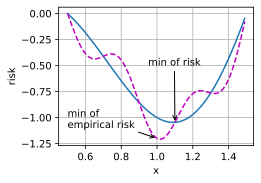

In [7]:
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(
        text,
        xy=xy,
        xytext=xytext,
        arrowprops=dict(arrowstyle='->')
    )


x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((5.5, 3.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of \nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

### 12.1.2. Optimization Challenges in Deep Learning

In deep learning, most objective functions are complicated and do not have analytical solutions.

#### 12.1.2.1. Local Minima

For any objective function $f(x)$, if the value of $f(x)$ at $x$ is smaller than the value of $f(x)$ at any other points in the vicinity of $x$, then $f(x)$ could be a local minimum. If the value of $f(x)$ at $x$ is the minimum of the objective function over the entire domain, then $f(x)$ is the global minimum.

For example, given the function
\begin{split}
f(x) = x \cdot \textrm{cos}(\pi x) \textrm{ for } -1.0 \leq x \leq 2.0,
\end{split}

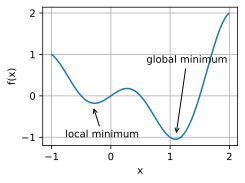

In [8]:
x = torch.arange(-1.0, 2.0, 0.01)

d2l.plot(x, [f(x),], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

When the numerical solution of an optimization problem is near the local optimum, the numerical solution obtained by the final iteration may only minimize the objective function *locally*, rather than **globally**, as the gradient of the objective function’s solutions approaches or becomes zero.

#### 12.1.2.2. Saddle Points

Besides local minima, saddle points are another reason for gradients to vanish. 

A *saddle point* is any location where all gradients of a function vanish but which is neither a glocal nor a local minimum.

Consider the function $f(x) = x^3$,

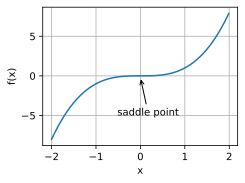

In [9]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

Saddle points in higher dimensions are even more insidious. Consider the function $f(x, y) = x^2 - y^2$. It has its saddle point at (0,0).

Text(0.5, 0.5, 'y')

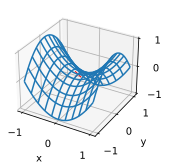

In [12]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), # x
    torch.linspace(-1.0, 1.0, 101)  # y
)
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y')

Assume that the input of a function is a $k$-dimensional vector and its output is a scalar, so its Hessian matrix will have $k$ eigenvalues. The solution of the function could be a local minimum, a local maximum, or a saddle point at a position where the function gradient is zero:
* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are all positive, we have a local minimum for the function.
* When the eigenvalues of the function’s Hessian matrix at the zero-gradient position are all negative, we have a local maximum for the function.
* When the eigenvalues of the function’s Hessian matrix at the zero-gradient position are negative and positive, we have a saddle point for the function.

Convex functions are those where the eigenvalues of the Hessian are never negative.

#### 12.1.2.3. Vanishing Gradients

Assume that we want to minimize the function $f(x)=\tanh(x)$. The derivative of this function is $f'(x)=1-\tanh^2(x)$. At $x=4$, $f'(x)=0.0013$, which is very close to zero. The optimization will get stuck for a long time before we make progress.

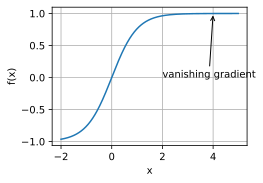

In [13]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

## 12.2. Convexity

In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d

from d2l import torch as d2l

### 12.2.1. Definitions

#### 12.2.1.1. Convex Sets

Sets are the basis of convexity. A set $\mathcal{X}$ in a vector space is *convex* if for any $a, b \in \mathcal{X}$ the line segment connecting $a$ and $b$ is also in $\mathcal{X}$. This means that for all $\lambda \in [0, 1]$, we have
\begin{split}
\lambda  a + (1-\lambda)  b \in \mathcal{X} \textrm{ whenever } a, b \in \mathcal{X}
\end{split}

![](../imgs/ch12/pacman.svg)

In the figure above, the first set is not convex since there exist line segments that are not contained in it.

![](../imgs/ch12/convex-intersect.svg)

In the figure above, assume that $\mathcal{X}$ (the left set) and $\mathcal{Y}$ (the middle set) are convex sets. Then $\mathcal{X} \cap \mathcal{Y}$ (the right set) is also a convex set.

Given convex sets $\mathcal{X}_i$, their intersection $\cap_i \mathcal{X}_i$ is also a convex set.

The problems in deep learning are defined on convex sets. For instance, $\mathbb{R}^d$, the set od $d$-dimensional vectors of real numbers, is a convex set (after all, the line between any two points in $\mathbb{R}^d$ remains in $\mathbb{R}^d$).

#### 12.2.1.2. Convex Functions

Given a convex set $\mathcal{X}$, a function $f: \mathcal{X} \rightarrow \mathbb{R}$ is *convex* if for all $x, x' \in \mathcal{X}$ and for all $\lambda \in [0, 1]$, we have
\begin{split}
\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x')
\end{split}

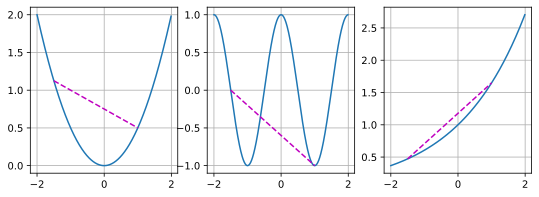

In [3]:
# examples
f = lambda x: 0.5 * x**2 # convex
g = lambda x: torch.cos(np.pi * x) # nonconvex
h = lambda x: torch.exp(0.5 * x) # convex

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])

d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f,g,h]):
    d2l.plot([x, segment],
             [func(x), func(segment)],
             axes=ax)

#### 12.2.1.3. Jensen's Inequality

Given a convex function $f$, the *Jensen's inequality* states that
\begin{split}
\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right)    \textrm{ and }    E_X[f(X)]  \geq f\left(E_X[X]\right),
\end{split}
where $\alpha_i$ are non-negative real numbers such that $\sum_i \alpha_i = 1$ and $X$ is a random variable. In other words, the expectation of a convex function is no less than the convex function of an expectation, where the latter is usually a simpler expression.

We can use Jensen's inequality to bound a more complicated expression by a simpler one. For example, in the log-likelihood of partially observed random variables, we use
\begin{split}
E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X)
\end{split}
since $\int P(Y) P(X \mid Y) dY = P(X)$. This can be used in variational methods. $Y$ is typically the unobserved random variable, $P(Y)$ is the best guess of how it might be distributed, and $P(X)$ is the distribution with $Y$ integrated out. In clustering $Y$ may be the cluster labels and $P(X \mid Y)$ is the generative model when applying cluster labels.

### 12.2.2. Properties

#### 12.2.2.1. Local Minima are Global Minima

The local minima of convex functions are also the global minima.

Consider a convex function $f$ defined on a convex set $\mathcal{X}$. Suppose that $x^*\in \mathcal{X}$ is a local minimum: there exists a small postive value $p$ so that for $x\in \mathcal{X}$ that satisfies $0 < |x - x^{\ast}| \leq p$, we have $f(x^{\ast}) \leq f(x)$.

Assume that the local minimum $x^*$ is not the global minimum of $f$: these exists $x' \in \mathcal{X}$ for which $f(x') < f(x^*)$. There also exists $\lambda\in [0,1)$ such that $\lambda = 1 - \frac{p}{|x^{\ast} - x'|}$ so that $0 < |\lambda x^{\ast} + (1-\lambda) x' - x^{\ast}| \leq p$.

However, according to the definition of convex functions, we have
\begin{split}\begin{aligned}
    f(\lambda x^{\ast} + (1-\lambda) x') &\leq \lambda f(x^{\ast}) + (1-\lambda) f(x') \\
    &< \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \\
    &= f(x^{\ast}),
\end{aligned}\end{split}
which contradicts with our statement that $x^{\ast}$ is a local minimum. Therefore, there does not exist $x' \in \mathcal{X}$ for which $f(x') < f(x^*)$. The local minimum $x^*$ is also the global minimum of $f$.

For instance, the convex function $f(x) = (x-1)^2$ has a local minimum at $x=1$, which is also the global minimum.

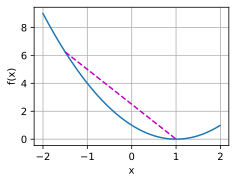

In [4]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

#### 12.2.2.2. Below Sets of Convex Functions are Convex

Given a convex function $f$ defined on a convext set $\mathcal{X}$, any *below set*
\begin{split}
\mathcal{S}_b \stackrel{\textrm{def}}{=} \{x | x \in \mathcal{X} \textrm{ and } f(x) \leq b\}
\end{split}
is convex.

Recall that for any $x, x' \in \mathcal{S}_b$ we need to show that $\lambda x + (1-\lambda) x' \in \mathcal{S}_b$ as long as $\lambda \in [0, 1]$. Since $f(x) \leq b$ and $f(x') \leq b$, we have
\begin{split}
f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b.
\end{split}

#### 12.2.2.3. Convexity and Second Derivatives

Whenver the second derivative of a function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ exists it is very easy to check whether $f$ is convex. All we need to do is check whether the Hessian of $f$ is positive semidefinite: $\nabla^2f \succeq 0$, i.e., denoting the Hessian matrix $\nabla^2f$ by $\mathbf{H}$, $\mathbf{x}^\top \mathbf{H} \mathbf{x} \geq 0$ for all $\mathbf{x} \in \mathbb{R}^n$.

A twice-differentiable one-dimensional function $f: \mathbb{R} \rightarrow \mathbb{R}$ is convex if and only if its second derivative $f''(x) \geq 0$.

A twice-differentiable multidimensional function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ is convex if and only if its Hessian matrix $\nabla^2f \succeq 0$.

### 12.2.3. Constraints

The convex optimization allows us to solve *constrained optimization* problems of the form:
\begin{split}\begin{aligned} \mathop{\textrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \textrm{ subject to } & c_i(\mathbf{x}) \leq 0 \textrm{ for all } i \in \{1, \ldots, n\},
\end{aligned}\end{split}
where $f$ is the objective and the functions $c_i$ are constraint functions.

#### 12.2.3.1. Lagrangian

Derived from the physics, the *Lagrangian* is a function defined via the following saddle-point optimization problem:
\begin{split}
L(\mathbf{x}, \alpha_1, \ldots, \alpha_n) = f(\mathbf{x}) + \sum_{i=1}^n \alpha_i c_i(\mathbf{x}) \textrm{ where } \alpha_i \geq 0.
\end{split}
where the $\alpha_i (i=1,...,n)$ are the *Lagrange multipliers* that ensure that constraints are properly enforced. They are chosen just large enough to ensure that $c_i(\mathbf{x}) \leq 0$ for all $i$.

For example, for any $\mathbf{x}$ where $c_i(\mathbf{x}) <0$ naturally, we would end up picking $\alpha_i=0$. This is a saddle point optimization problem where one wants to *maximize* $L$ with respect to all $\alpha_i$ and simultaneously *minimize* $L$ with respect to $\mathbf{x}$.

#### 12.2.3.2. Penalties

One way to satisfying constrained optimization problems at least *approximately* is to adapt the Langrangian $L$. Rather than satisfying $c_i(\mathbf{x}) \leq 0$, we simply add $\alpha_i c_i(\mathbf{x})$ to the objective function $f(x)$.

In general, adding penalties is a good way of ensuring approximate constraint satisfaction. In practice this turns out to be much more robust than exact satisfaction. Furthermore, for nonconvex problems many of the properties that make the exact approach so appealing in the convex case (e.g., optimality) no longer hold.

#### 12.2.3.3. Projections

An alternative strategy for satisfying constraints is projections. For example, when dealing with gradient clipping. We ensured that a gradient has length bounded by $\theta$ via
\begin{split}
\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, \theta/\|\mathbf{g}\|).
\end{split}

This turns out to be a *projections* of $\mathbf{g}$ onto the ball of radius $\theta$. More generally, a projection on a convex set $\mathcal{X}$ is defined as
\begin{split}
\textrm{Proj}_\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in \mathcal{X}} \|\mathbf{x} - \mathbf{x}'\|,
\end{split}
which is the closest point in $\mathcal{X}$ to $\mathbf{x}$.

## 12.3. Gradient Descent

### 12.3.1. One-Dimensional Gradient Descent

Consider some continuously differentiable real-valued function $f: \mathbb{R} \rightarrow \mathbb{R}$. Using a Taylor expansion, we get
\begin{split}
f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).
\end{split}
In first-order approximation $f(x + \epsilon)$ is given by the function value $f(x)$ and the first derivative $f'(x)$ at $x$. For simplicity we pick a fixed step size $\epsilon > 0$ and choose $\epsilon = -\eta f'(x)$, and then we get
\begin{split}
f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).
\end{split}

If the derivative $f'(x) \neq 0$ does not vanish, we can make progress since $\eta f'^2(x) > 0$. If we choose $\eta$ small enough for the higher-order terms to be negligible, we get
\begin{split}
f(x - \eta f'(x)) \lessapprox f(x).
\end{split}

If we use 
\begin{split}
x \leftarrow x - \eta f'(x)
\end{split}
to iterate $x$, the value of function $f(x)$ may decrease. Therefore, in gradient descent we first choose an initial value $x$ and a constant $\eta > 0$, and then use them to continuously iterate $x$ until the stop condition is reached.



In [1]:
%matplotlib inline
import numpy as np
import torch

from d2l import torch as d2l

In [2]:
def f(x):
    # objective function
    return x ** 2

def f_grad(x):
    # gradient of the objective function
    return 2 * x

In [3]:
def gd(eta, f_grad):
    # gradient descent
    x = 10.0 # initial value
    results = [x] # store all steps
    steps = 10 # number of iterations
    for i in range(steps):
        # update x
        x -= eta * f_grad(x)
        # store it
        results.append(float(x))
        print(f'epoch {i + 1}, x: {x:f}')

    return results

eta = 0.2 # learning rate
results = gd(eta, f_grad)

epoch 1, x: 6.000000
epoch 2, x: 3.600000
epoch 3, x: 2.160000
epoch 4, x: 1.296000
epoch 5, x: 0.777600
epoch 6, x: 0.466560
epoch 7, x: 0.279936
epoch 8, x: 0.167962
epoch 9, x: 0.100777
epoch 10, x: 0.060466


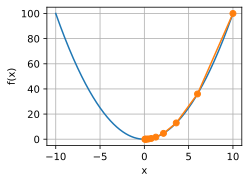

In [4]:
# show the results
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)

    d2l.set_figsize()
    d2l.plot(
        [f_line, results],
        [[f(x) for x in f_line], [f(x) for x in results]],
        'x', 'f(x)',
        fmts=['-', '-o']
    )

show_trace(results, f)

#### 12.3.1.1. Learning Rate

If we use a learning rate that is too small, it will cause $x$ to update very slowly, requiring more iterations to get a better solution.

epoch 1, x: 9.600000
epoch 2, x: 9.216000
epoch 3, x: 8.847360
epoch 4, x: 8.493466
epoch 5, x: 8.153727
epoch 6, x: 7.827578
epoch 7, x: 7.514475
epoch 8, x: 7.213896
epoch 9, x: 6.925340
epoch 10, x: 6.648326


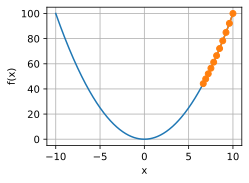

In [7]:
eta = 0.02
show_trace(gd(eta, f_grad), f)

If we use an excessively high learning rate, $\left|\eta f'(x)\right|$ may be too large for the first-order Taylor expansion formula. The term $\mathcal{O}(\eta^2 f'^2(x))$ may become significant. In this case, we cannot guarantee that the iteration of $x$ will be able to lower the value of $f(x)$.

epoch 1, x: -12.000000
epoch 2, x: 14.400000
epoch 3, x: -17.280000
epoch 4, x: 20.736000
epoch 5, x: -24.883200
epoch 6, x: 29.859840
epoch 7, x: -35.831808
epoch 8, x: 42.998170
epoch 9, x: -51.597804
epoch 10, x: 61.917364


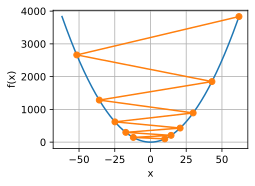

In [8]:
eta = 1.1
show_trace(gd(eta, f_grad), f)

#### 12.3.1.2. Local Minima

Consider the case of $f(x) = x\cdot \cos(cx)$ for some constant $c$.

In [9]:
c = torch.tensor(0.15 * np.pi)

def f(x):
    # objective function
    return x * torch.cos(c * x)

def f_grad(x):
    # gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

epoch 1, x: 9.057522
epoch 2, x: 8.372623
epoch 3, x: 7.943189
epoch 4, x: 7.684419
epoch 5, x: 7.527670
epoch 6, x: 7.431408
epoch 7, x: 7.371584
epoch 8, x: 7.334085
epoch 9, x: 7.310442
epoch 10, x: 7.295479


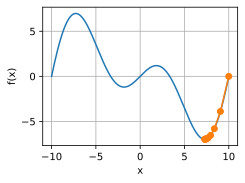

In [10]:
eta = 0.2
show_trace(gd(eta, f_grad), f)

epoch 1, x: 0.575222
epoch 2, x: -1.206588
epoch 3, x: -2.279598
epoch 4, x: -1.343416
epoch 5, x: -2.206769
epoch 6, x: -1.425789
epoch 7, x: -2.154634
epoch 8, x: -1.483876
epoch 9, x: -2.114354
epoch 10, x: -1.528166


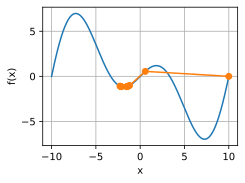

In [11]:
eta = 2
show_trace(gd(eta, f_grad), f)

### 12.3.2. Multivariate Gradient Descent

Consider the situation where $\mathbf{x} = [x_1, x_2, \ldots, x_d]^\top$. That is, the objective function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ maps vectors to scalars. Its gradient is given by a $d$-dimensional vector of partial derivatives:
\begin{split}
\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.
\end{split}

Using the corresponding Taylor approximation for multivariate functions, we get
\begin{split}
f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\boldsymbol{\epsilon}\|^2).
\end{split}
In other words, up to second-order terms in $\boldsymbol{\epsilon}$, the direction of steepest descent is given by the negative gradient $-\nabla f(\mathbf{x})$. Choosing a suitable learning rate $\eta > 0$ yields the prototypical gradient descent algorithm:
\begin{split}
\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).
\end{split}

For example, consider the function $f(\mathbf{x}) = x_1^2 + 2 x_2^2$ whose gradient is given by $\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$. We initialize $\mathbf{x} = [-5, -2]^\top$ and use $\eta = 0.1$ as the learning rate for 20 times.

In [13]:
def train_2d(trainer, steps=20, f_grad=None):
    '''Optimize a 2d objective function with a customized trainer'''
    x1, x2 = -5, -2
    # s1 and s2 are internal state variables that will be used in momentum, adagrad, rmsprop
    s1, s2 = 0, 0

    # store all the variables
    results = [(x1, x2)]

    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        
        results.append((x1, x2))
        print(f'epoch {i + 1}, x1 {float(x1):f}, x2 {float(x2):f}')
    return results

def show_trace_2d(f, results):
    '''Show the trace of 2d variables during optimization'''
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    
    x1, x2 = torch.meshgrid(
        torch.arange(-5.5, 1.0, 0.1), # x1
        torch.arange(-3.0, 1.0, 0.1),  # x2
        indexing='ij', # matrix indexing
    )

    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

In [14]:
def f_2d(x1, x2):
    # objective function
    return x1**2 + 2 * x2**2

def f_2d_grad(x1, x2):
    # gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    # gradient descent
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0) # x1, x2, s1, s2

epoch 1, x1 -4.000000, x2 -1.200000
epoch 2, x1 -3.200000, x2 -0.720000
epoch 3, x1 -2.560000, x2 -0.432000
epoch 4, x1 -2.048000, x2 -0.259200
epoch 5, x1 -1.638400, x2 -0.155520
epoch 6, x1 -1.310720, x2 -0.093312
epoch 7, x1 -1.048576, x2 -0.055987
epoch 8, x1 -0.838861, x2 -0.033592
epoch 9, x1 -0.671089, x2 -0.020155
epoch 10, x1 -0.536871, x2 -0.012093
epoch 11, x1 -0.429497, x2 -0.007256
epoch 12, x1 -0.343597, x2 -0.004354
epoch 13, x1 -0.274878, x2 -0.002612
epoch 14, x1 -0.219902, x2 -0.001567
epoch 15, x1 -0.175922, x2 -0.000940
epoch 16, x1 -0.140737, x2 -0.000564
epoch 17, x1 -0.112590, x2 -0.000339
epoch 18, x1 -0.090072, x2 -0.000203
epoch 19, x1 -0.072058, x2 -0.000122
epoch 20, x1 -0.057646, x2 -0.000073


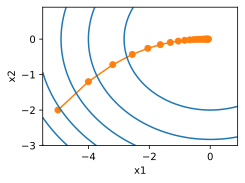

In [15]:
eta = 0.1
show_trace_2d(
    f_2d,
    train_2d(gd_2d, f_grad=f_2d_grad),
)

### 12.3.3. Adaptive Methods

#### 12.3.3.1. Newton's Method

We can write the Taylor expansion of $f: \mathbb{R}^d \rightarrow \mathbb{R}$ as
\begin{split}
f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).
\end{split}

We define $\mathbf{H} \stackrel{\textrm{def}}{=} \nabla^2 f(\mathbf{x})$ to be the Hessian of $f$, which is a $d \times d$ matrix. For small $d$ and simple problems, $\mathbf{H}$ is easy to compute.

The minimum of $f$ satisfies $\nabla f(\mathbf{x}) = 0$. After taking derivatives with regard to $\boldsymbol{\epsilon}$ and ignoring higher-order terms, we get
\begin{split}
\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \textrm{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).
\end{split}
That is, we need to invert the Hessian $\mathbf{H}$ as part of the optimization problem.

Given a convex hyperbolic cosine function $f(x)=\cosh(cx)$, 

In [16]:
# Example
c = torch.tensor(0.5)

def f(x):
    # objective function
    return torch.cosh(c * x)

def f_grad(x):
    # gradient of the objective function
    return c * torch.sinh(c * x)

def f_hess(x):
    # hessian of the objective function
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    # newton's method

    # initial value
    x = 10.0
    results = [x]
    steps = 10
    for i in range(steps):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
        print(f'epoch {i + 1}, x: {x:f}')
    return results

epoch 1, x: 8.000181
epoch 2, x: 6.001523
epoch 3, x: 4.011398
epoch 4, x: 2.082542
epoch 5, x: 0.525763
epoch 6, x: 0.011786
epoch 7, x: 0.000000
epoch 8, x: 0.000000
epoch 9, x: 0.000000
epoch 10, x: 0.000000


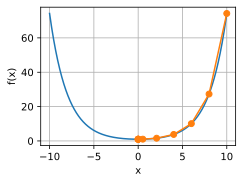

In [17]:
eta = 1
show_trace(newton(eta), f)

Consider a *nonconvex* function $f(x)=x \cdot \cos(cx)$.

In [18]:
c = torch.tensor(0.15 * np.pi)

def f(x):
    # objective function
    return x * torch.cos(c * x)

def f_grad(x):
    # gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):
    # hessian of the objective function
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

epoch 1, x: 5.000000
epoch 2, x: 24.994869
epoch 3, x: 27.783125
epoch 4, x: 26.800097
epoch 5, x: 26.834177
epoch 6, x: 26.834131
epoch 7, x: 26.834133
epoch 8, x: 26.834133
epoch 9, x: 26.834133
epoch 10, x: 26.834133


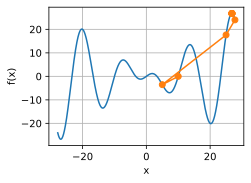

In [19]:
eta = 1
show_trace(newton(eta), f)

To fix this, we may want to reduce the learning rate:

epoch 1, x: 7.500000
epoch 2, x: 7.387165
epoch 3, x: 7.329002
epoch 4, x: 7.299392
epoch 5, x: 7.284441
epoch 6, x: 7.276928
epoch 7, x: 7.273161
epoch 8, x: 7.271276
epoch 9, x: 7.270332
epoch 10, x: 7.269860


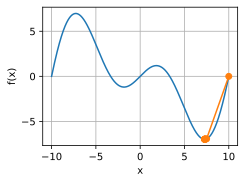

In [20]:
eta = 0.5
show_trace(newton(eta), f)

#### 12.3.3.2. Convergence Analysis

Denote by $x^{(k)}$ the value of $x$ at the $k$-th iteration and let $e^{(k)} \stackrel{\textrm{def}}{=} x^{(k)} - x^*$ be the distance from optimality at the $k$-th iteration. By Taylor expansion we have that the condition $f'(x^*) = 0$ can be written as
\begin{split}
0 = f'(x^{(k)} - e^{(k)}) = f'(x^{(k)}) - e^{(k)} f''(x^{(k)}) + \frac{1}{2} (e^{(k)})^2 f'''(\xi^{(k)}),
\end{split}
which holds for some $\xi^{(k)} \in [x^{(k)} - e^{(k)}, x^{(k)}]$. Dividing the above expansion by $f''(x^{(k)})$ yields
\begin{split}
e^{(k)} - \frac{f'(x^{(k)})}{f''(x^{(k)})} = \frac{1}{2} (e^{(k)})^2 \frac{f'''(\xi^{(k)})}{f''(x^{(k)})}.
\end{split}

Recall the update $x^{(k+1)} = x^{(k)} - f'(x^{(k)}) / f''(x^{(k)})$. Plugging this into the above equation and taking the absolute value of both sides, we have
\begin{split}
\left|e^{(k+1)}\right| = \frac{1}{2}(e^{(k)})^2 \frac{\left|f'''(\xi^{(k)})\right|}{f''(x^{(k)})}.
\end{split}

Consequently, whenever we are in a region of bounded $\left|f'''(\xi^{(k)})\right| / (2f''(x^{(k)})) \leq c$, we have a quadratically decreasing error
\begin{split}
\left|e^{(k+1)}\right| \leq c (e^{(k)})^2.
\end{split}
This is called the *linear* convergence, whereas a condition such as $\left|e^{(k+1)}\right| \leq \alpha \left|e^{(k)}\right|$ would be called a *constant* rate of convergence.

#### 12.3.3.3. Preconditioning

It is expensive to compute and store the full Hessian. One way to improve is *preconditioning*. It avoids computing the Hessian in its entirety but only computes the *diagonal* entries. This leads to update algorithms of the form
\begin{split}
\mathbf{x} \leftarrow \mathbf{x} - \eta \textrm{diag}(\mathbf{H})^{-1} \nabla f(\mathbf{x}).
\end{split}

#### 12.3.3.4. Gradient Descent with Line Search

One way to ensure that we can make progress is to use a *line search* algorithm in conjunction with gradient descent. That is, we use the direction given by $\nabla f(\mathbf{x})$ and then perform binary search as to which learning rate $\eta$ minimizes $f(\mathbf{x} - \eta \nabla f(\mathbf{x}))$.

## 12.4. Stochastic Gradient Descent

In [3]:
%matplotlib inline
import math
import torch

from d2l import torch as d2l

### 12.4.1. Stoachastic Gradient Updates

In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset.

Given a training dataset of $n$ examples, $f_i(\mathbf{x})$ is the loss function with respect to the training example of index $i$, where $\mathbf{x}$ is the parameter vector. Then the objective function is
\begin{split}
f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).
\end{split}

The gradient of the objective function at $\mathbf{x}$ is
\begin{split}
\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).
\end{split}

If gradient descent is used, the computational cost for each independent variable iteration is $\mathcal{O}(n)$.

The *Stochastic Gradient Descent* (SGD) algorithm reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i \in \{1, 2, \ldots, n\}$ for data examples at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:
\begin{split}
\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),
\end{split}
where $\eta$ is the learning rate. The computational cost for each iteration drops from $\mathcal{O}(n)$ of the full gradient descent to $\mathcal{O}(1)$.

The stochastic gradient $\nabla f_i(\mathbf{x})$ is the unbiased estimate of the full gradient $\nabla f(\mathbf{x})$ because
\begin{split}
\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}),
\end{split}
which means that, on average, the stochastic gradient is a good estimate of the gradient.

We can compare the stochastic gradient descent algorithm with the gradient descent algorithm by adding random noise with a mean of 0 and a variance of 1 to the gradient to simulate a stochastic gradient descent algorithm:

In [4]:
def f(x1, x2):
    # objective function
    return x1**2 + 2 * x2**2

def f_grad(x1, x2):
    # gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    # stochastic gradient descent
    # gradient
    g1, g2 = f_grad(x1, x2)
    # simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    # step
    eta_t = eta * lr()

    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0) # x1, x2, s1, s2

def constant_lr():
    return 1

epoch 50, x1: -0.098303, x2: -0.036012


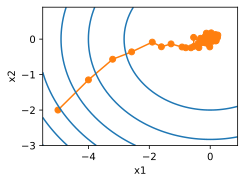

In [5]:
# learning rate decay
eta = 0.1
# learning rate
lr = constant_lr # constant learning rate

d2l.show_trace_2d(
    f, # objective function
    d2l.train_2d(
        sgd,
        steps=50,
        f_grad=f_grad,
    )
)

The trajectory of the variables in the SGD is much more noisy than the one in gradient descent. This is due to the stochastic nature of the gradient. In practice, this noise is actually helpful for escaping from local minima. However, it will not improve after additional steps:

epoch 100, x1: -0.199283, x2: 0.289604


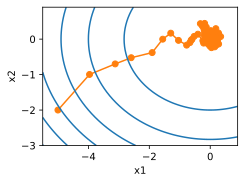

In [6]:
# learning rate decay
eta = 0.1
# learning rate
lr = constant_lr # constant learning rate

d2l.show_trace_2d(
    f, # objective function
    d2l.train_2d(
        sgd,
        steps=100,
        f_grad=f_grad,
    )
)

The only way to resolve the issue of selecting a good learning rate is to reduce the learning rate *dynamically* as optimization progresses.

### 12.4.2. Dynamic Learning Rate

Replacing $\eta$ with a time-dependent learning rate $\eta(t)$ adds to the complexity of controlling convergence of an optimization algorithm. Some common strategies include
\begin{split}\begin{aligned}
    \eta(t) & = \eta_i \textrm{ if } t_i \leq t \leq t_{i+1}  && \textrm{piecewise constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \textrm{exponential decay} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \textrm{polynomial decay}
\end{aligned}\end{split}

For the exponential decay,

epoch 1000, x1: -0.815040, x2: -0.059181


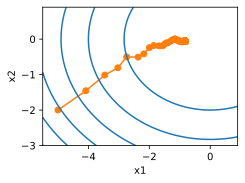

In [7]:
def exponential_lr():
    # global variable that is defined outside this function and update inside
    global t

    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr

d2l.show_trace_2d(
    f, # objective function
    d2l.train_2d(
        sgd,
        steps=1000,
        f_grad=f_grad,
    )
)

As expected, the variance in the parameters is significantly reduced, even though it cannot converge to the optimal solution $\mathbf{x}=(0,0)$ after 1000 steps.

If we use a polynomial decay where the learning rate decays with the inverse square root of the number of steps, convergence gets better after only 50 steps:

epoch 50, x1: 0.115200, x2: 0.032597


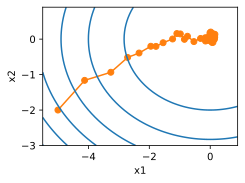

In [8]:
def ploynomial_lr():
    # global variable that is defined outside this function and update inside
    global t

    t += 1
    return (1 + 0.1 * t)**(-0.5)

t = 1
lr = ploynomial_lr

d2l.show_trace_2d(
    f, # objective function
    d2l.train_2d(
        sgd,
        steps=50,
        f_grad=f_grad,
    )
)

## 12.5. Minibatch Stochastic Gradient Descent

### 12.5.1. Vectorization and Caches

Consider matrix-matrix multiplication, for example, $\mathbf{A}=\mathbf{BC}$. We have a number of options for calculating $\mathbf{A}$:
1. Compute $\mathbf{A}_{ij}= \mathbf{B}_{i,:}\mathbf{C}_{:,j}$, i.e., compute it elementwise by means of dot products
2. Compute $\mathbf{A}_{:, j} = \mathbf{B}\mathbf{C}_{:,j}$, i.e., compute it one column at a time. Likewise, we can compute $\mathbf{A}$ one row $\mathbf{A}_{i,:}$ at a time
3. Compute $\mathbf{A} = \mathbf{BC}$ in one operation
4. Break $\mathbf{B}$ and $\mathbf{C}$ into smaller block matrices and compute $\mathbf{A}$ one block at a time 

In [3]:
%matplotlib inline
import time
import numpy as np
import torch
from torch import nn

from d2l import torch as d2l

In [19]:
# example:
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

In [20]:
class Timer:
    '''Record multiple running times'''
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        '''Start the timer'''
        self.tik = time.time()

    def stop(self):
        '''Stop the timer and record the time in a list'''
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        '''Return the average time'''
        return sum(self.times) / len(self.times)
    
    def sum(self):
        '''Return the sum of time'''
        return sum(self.times)
    
    def cumsum(self):
        '''Return the accumuated times'''
        return np.array(self.times).cumsum().tolist()

In [25]:
# create a timer instance
timer = Timer()

In [26]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i,j] = torch.dot(B[i,:], C[:,j])
timer.stop()

1.2476117610931396

In [27]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:,j] = torch.mv(B, C[:,j])
timer.stop()

0.00659632682800293

In [28]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

0.0009980201721191406

Multiplying any two matrices $\mathbf{B}\in \mathbb{R}^{m\times n}$ and $\mathbf{C}\in \mathbb{R}^{n\times p}$ takes approximately $2mnp$ floating point operations, when scalar multiplication and addition are counted as separate operations. Thus, multiplying two $256\times 256$ matrices takes $2\times 256\times 256\times 256\approx 0.033$ billion floating point operations:

In [29]:
gigaflops = [0.033 / i for i in timer.times]
print(f'perforamnce in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

perforamnce in Gigaflops: element 0.026, column 5.003, full 33.065


### 12.5.2. Minibatches

Processing single observations requires us to perform many single matrix-vector (or even vector-vector) multiplications, which is quite expensive and which incurs a significant overhead on behalf of the underlying deep learning framework. This applies whenever we perform $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ where
\begin{split}
\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})
\end{split}

To increase the *computational efficiency*, we can apply to a minibatch of observations at a time. We replace the gradient $\mathbf{g}_t$ over a single observation by one over a small batch
\begin{split}
\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})
\end{split}

Since both $\mathbf{x}_t$ and also all elements of the minibatch $\mathcal{B}_t$ are drawn uniformly at random from the training set, the expectation of the gradient remains unchanged. The variance is reduced significantly. Since the minibatch gradient is composed of $b \stackrel{\textrm{def}}{=} |\mathcal{B}_t|$ independent gradients which are being averaged, its standard deviation is reduced by a factor of $b^{-\frac{1}{2}}$. 

In practice we pick a minibatch that is large enough to offer good computational efficiency while still fitting into the memory of a GPU.

In [33]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()

print(f'performance in Gigaflops: block {0.03 / timer.times[2]:.3f}')

performance in Gigaflops: block 30.060


### 12.5.3. Reading the Dataset

Load a dataset developed by NASA to test the wing noise from different aircraft. The data is whitened for preprocessing, i.e., we remove the mean and rescale the variance to 1 per coordinate.

In [34]:
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch12(batch_size=10, n=1500):
    '''Get the dataset

    Parameters
    ----------
    batch_size : int
        The batch size of dataset, default 10
    n : int
        The number of examples, default 1500

    Returns
    -------
    data_iter : torch.utils.data.DataLoader
        The dataset iterator
    num_inputs : int
        The number of features
    '''
    data = np.genfromtxt(d2l.download('airfoil'), dtype=np.float32, delimiter='\t')
    # normalize features (whitening)
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]), batch_size, is_train=True)

    return data_iter, data.shape[1] - 1

### 12.5.4. Implementation from Scratch

In [35]:
def sgd(params, states, hyperparams):
    '''Minibatch stochastic gradient descent from scratch
    
    Parameters
    ----------
    params : list
        A list of parameters to be updated
    states : list
        A list of state variables corresponding to `params`
    hyperparams : dict
        A dictionary of hyperparameters
    '''
    for p in params:
        # update p
        p.data.sub_(hyperparams['lr'] * p.grad) # p -= lr * p.grad
        # zero gradient
        p.grad.data.zero_()

    # for minibatch SGD, we don't need to update states

Next, we will implement a generic training function to facilitate the use of the other optimization algorithms. It initializes a linear regression model and can be used to train the model with minibatch stochastic gradient descent and other algorithms

In [39]:
def train_ch12(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    '''Train a linear regression model
    
    Parameters
    ----------
    trainer_fn : function
        The trainer function to be used
    states : list
        A list of state variables to be passed to `trainer_fn`
    hyperparams : dict
        A dictionary of hyperparameters to be passed to `trainer_fn`
    data_iter : torch.utils.data.DataLoader
        The dataset iterator
    feature_dim : int
        The number of features
    num_epochs : int
        The number of epochs, default 2
    '''

    # initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net = lambda X: d2l.linreg(X, w, b)
    loss = d2l.squared_loss

    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    
    n = 0
    timer = d2l.Timer()

    for _ in range(num_epochs):
        for X,y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()

            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(
                    n / X.shape[0] / len(data_iter),
                    (d2l.evaluate_loss(net, data_iter, loss),)
                )
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

In [47]:
def train_sgd(lr, batch_size, num_epochs=2):
    '''Train a linear regression model with a given hyperparameter setting
    
    Parameters
    ----------
    lr : float
        Learning rate
    batch_size : int
        Batch size
    num_epochs : int
        Number of epochs, default 2
    '''
    data_iter, feature_dim = get_data_ch12(batch_size)
    return train_ch12(sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

For batch gradient descent, we set the minibatch size to 1500 (i.e., the total number of examples). The model parameters are updated only once per epoch.

loss: 0.247, 0.016 sec/epoch


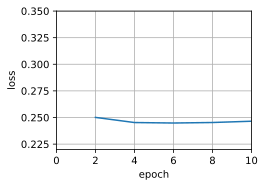

In [48]:
gd_res = train_sgd(lr=1, 
                   batch_size=1500, 
                   num_epochs=10)

For stochastic gradient descent, we set the batch size to 1 and also need to pick a much smaller learning rate. In stochastic gradient descent, the model parameters are updated whenever an example is processed. In our case this amounts to 1500 updates per epoch. Although both the procedures processed 1500 examples within one epoch, stochastic gradient descent consumes more time than gradient descent in our experiment. This is because stochastic gradient descent updated the parameters more frequently and since it is less efficient to process single observations one at a time.

loss: 0.246, 0.439 sec/epoch


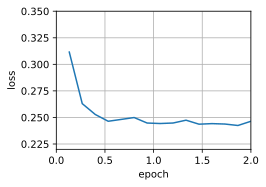

In [49]:
sgd_res = train_sgd(lr=0.005, 
                    batch_size=1, 
                    num_epochs=2)

Finally, we set the batch size to 100 to use minibatch stochastic gradient descent.

loss: 0.243, 0.022 sec/epoch


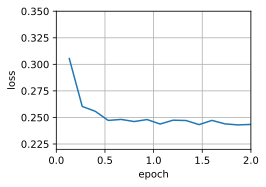

In [50]:
mini1_res = train_sgd(lr=.4, 
                      batch_size=100,
                      num_epochs=2)

Reducing the batch size to 10, the time for each epoch increases because the workload for each batch is less efficient to execute.

loss: 0.243, 0.061 sec/epoch


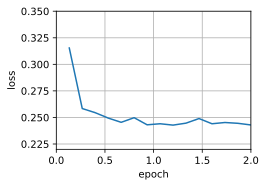

In [51]:
mini2_res = train_sgd(lr=0.05, 
                      batch_size=10,
                      num_epochs=2)

We can compare the time versus loss for the previous experiments:

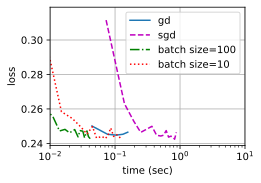

In [52]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

### 12.5.5. Concise Implementation

In Gluon, we can use the `Trainer` class to call optimization algorithms. This is used to implement a generic training function:

In [53]:
def train_concise_ch12(trainer_fn, hyperparams, data_iter, num_epochs=4):
    '''Train a linear regression model
    
    Parameters
    ----------
    trainer_fn : function
        The trainer function to be used
    hyperparams : dict
        A dictionary of hyperparameters to be passed to `trainer_fn`
    data_iter : torch.utils.data.DataLoader
        The dataset iterator
    num_epochs : int
        The number of epochs, default 4
    '''
    # initialization
    net = nn.Sequential(nn.Linear(5, 1))

    def init_weights(module):
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.01)
    
    # initialize model parameters
    net.apply(init_weights)

    # optimizer
    optimizer = trainer_fn(net.parameters(), **hyperparams)
    # loss function
    loss = nn.MSELoss(reduction='none')

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    
    n = 0
    timer = d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            # clear gradient
            optimizer.zero_grad()
            # forward pass
            out = net(X)

            y = y.reshape(out.shape)
            l = loss(out, y)
            # backward pass
            l.mean().backward()
            # update parameters
            optimizer.step()

            n += X.shape[0]
            if n% 200 == 0:
                timer.stop()
                # MSELoss computes squared error without the 1/2 factor
                animator.add(
                    n / X.shape[0] / len(data_iter),
                    (d2l.evaluate_loss(net, data_iter, loss) / 2,)
                )
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')

loss: 0.242, 0.071 sec/epoch


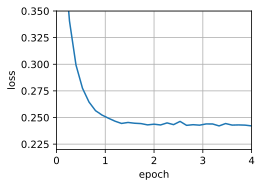

In [54]:
# Using Gluon to repeat the last experiment shows identical behavior
data_iter, _ = get_data_ch12(10)
trainer = torch.optim.SGD

train_concise_ch12(trainer, {'lr': 0.01}, data_iter)

## 12.6. Momentum

For noisy gradients, we need to be extra cautious when it comes to choosing the learning rate in the face of noise. If we decrease it too rapidly, convergence stalls. If we are too lenient, we fail to converge to a good enough solution since noise keeps on driving us away from optimality.

### 12.6.1. Basics

#### 12.6.1.1. Leaky Averages

The previous section demonstrates how minibatch SGD works as a means for accelerating computation and averaging gradients to reduce the amount of variance. The minibatch stochastic gradient descent can be calculated by:
\begin{split}
\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
\end{split}
where $\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$ is the stochastic gradient descent for sample $i$ using the weights updated at time $t-1$. To further reduce the variance on a minibatch, we can replace the gradient computation by a "leaky average":
\begin{split}
\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}
\end{split}
for some $\beta\in(0,1)$. This effectively replaces the instantaneous gradient by one that has been averaged over multiple *past* gradients. The $\mathbf{v}$ term is called *velocity* and accumulates past gradients similar to how a heavy ball rolling down the objective function landscape integrates over past forces.

We can expand $\mathbf{v}_t$ recursively as
\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}
where large $\beta$ amounts to a long-range average, and small $\beta$ amounts to a slight correction relative to a gradient method.

The new gradient replacement no longer points into the direction of steepest descent on a particular instance any longer but rather in the **direction of a weighted average of past gradients**. This benefits optimization by averaging over a batch without the cost of actually computing the gradient on it. This is known as *accelerated gradient* methods, such as with momentum.

#### 12.6.1.2. An Ill-conditioned Problem

For example, we use $f(\mathbf{x}) = x_1^2 + 2 x_2^2$ i.e., a moderately distorted ellipsoid objective function. The objective function in this section is:
\begin{split}
f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.
\end{split}
where $f$ has its minimum at (0,0). This function is very flat in the direction of $x_1$ and quite steep in the direction of $x_2$.

In [1]:
%matplotlib inline
import torch

from d2l import torch as d2l

In [2]:
def f_2d(x1, x2):
    # objective function
    return 0.1 * x1**2 + 2 * x2**2

def gd_2d(x1, x2, s1, s2):
    # gradient descent
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0) # x1, x2, s1, s2

epoch 20, x1: -0.943467, x2: -0.000073


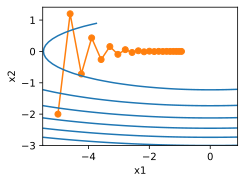

In [3]:
# learning rate
eta = 0.4

d2l.show_trace_2d(
    f_2d,
    d2l.train_2d(gd_2d),
)

The gradient in the $x_2$ direction is *much* higher and changes much more rapidly than in the horizontal $x_1$ direction. If we pick a small learning rate we ensure that the solution does not diverge in the $x_2$ direction but we are saddled with slow convergence in the $x_1$ direction. Conversely, with a large learning rate we progress rapidly in the $x_1$ direction but diverge in $x_2$:

epoch 20, x1: -0.387814, x2: -1673.365109


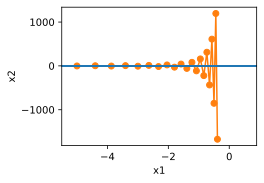

In [4]:
# larger learning rate
eta = 0.6

d2l.show_trace_2d(
    f_2d,
    d2l.train_2d(gd_2d),
)

#### 12.6.1.3. The Momentum Method

In the $x_1$ direction the momemtum method will aggregate well-aligned gradients, thus increasing the distance we cover with every step. Conversely, in the $x_2$ direction where gradients oscillate, an aggregate gradient will reduce step size due to oscillations that cancel each other out.

Using $\mathbf{v}_t$ instead of the gradient $\mathbf{g}_t$ yields the following update equations:
\begin{split}\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}\end{split}
For $\beta = 0$ we recover regular gradient descent.

In [5]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2 # x1, x2, v1, v2

epoch 20, x1: 0.007188, x2: 0.002553


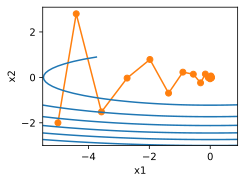

In [7]:
# learning rate
eta = 0.6 # using larger learning rate can lead to divergence
# momentum
beta = 0.5

d2l.show_trace_2d(
    f_2d,
    d2l.train_2d(momentum_2d),
)

Even with the same learning rate as in the previous experiments, momentum still converges well.

Halving the momentum to $\beta=0.25$ leads to a trajectory that barely converges at all. Nonetheless, it is a lot better than without momentum (when the solution diverges):

epoch 20, x1: -0.126340, x2: -0.186632


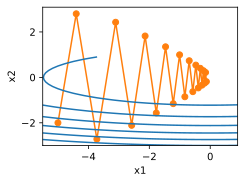

In [8]:
# learning rate
eta = 0.6 # using larger learning rate can lead to divergence
# momentum
beta = 0.25 # smaller momentum

d2l.show_trace_2d(
    f_2d,
    d2l.train_2d(momentum_2d),
)

#### 12.6.1.4. Effective Sample Weight

Recall that 
\begin{split}
\mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}
\end{split}
In the limit the terms add up to 
\begin{split}
\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}.
\end{split}
In other words, rather than taking a step of size $\eta$ in gradient descent or stochastic gradient descent, we take a step of size $\frac{\eta}{1-\beta}$ while at the same time, dealing with a potentially much better behaved descent direction.

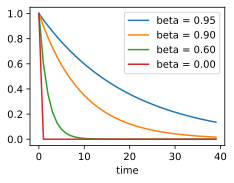

In [9]:
d2l.set_figsize()
# momenta
betas = [0.95, 0.9, 0.6, 0]

for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

### 12.6.2. Practical Experiments

#### 12.6.2.1. Implementation from Scratch

Compared with (minibatch) stochastic gradient descent, the *momentum* method needs to maintain a set of auxiliary variables, i.e., *velocity*. It has the same shape as the gradients (and variables of the optimization problem), which are called `states` in the following implementation.

In [10]:
def init_momentum_states(feature_dim):
    '''Initialize momentum states'''
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    '''Minibatch stochastic gradient descent with momentum
    
    Parameters
    ----------
    params : list
        A list of parameters to be updated
    states : list
        A list of momentum states to be updated
    hyperparams : dict
        A dictionary of hyperparameters
    '''
    for p, v in zip(params, states):
        with torch.no_grad():
            # update momentum
            v[:] = hyperparams['momentum'] * v + p.grad
            # update parameters
            p[:] -= hyperparams['lr'] * v

        # zero gradient
        p.grad.data.zero_()

In [11]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(
        sgd_momentum,
        init_momentum_states(feature_dim),
        {'lr':lr, 'momentum': momentum},
        data_iter,
        feature_dim,
        num_epochs
    )

loss: 0.244, 0.101 sec/epoch


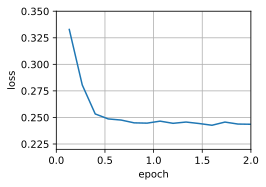

In [12]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)

# learning rate
lr = 0.02
# momentum
beta = 0.5
train_momentum(lr, beta)

When we increase the momentum hyperparameter `momentum` from 0.5 to 0.9, it amounts to a significantly larger effective sample size of $\frac{1}{1-0.9}=10$. We also need to reduce the learning rate slightly to 0.01 to keep matters under control:

loss: 0.247, 0.075 sec/epoch


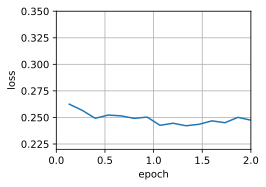

In [13]:
lr = 0.01
beta = 0.9

train_momentum(lr, beta)

Further reducing the learning rate yields good convergence behavior:

loss: 0.246, 0.075 sec/epoch


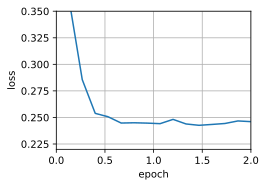

In [14]:
lr = 0.005
beta = 0.9

train_momentum(lr, beta)

#### 12.6.2.2. Concise Implementation

loss: 0.247, 0.080 sec/epoch


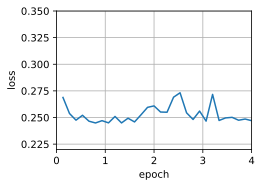

In [15]:
trainer = torch.optim.SGD

d2l.train_concise_ch11(
    trainer,
    {'lr': 0.005, 'momentum': 0.9},
    data_iter
)

### 12.6.3. Theoretical Analysis

#### 12.6.3.1. Quadratic Convex Functions

Consider the function
\begin{split}
h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b,
\end{split}
which is a general quadratic function. For positive definite matrices $\mathbf{Q} \succ 0$, i.e., for matrices with positive eigenvalues, this has a minimizer at $\mathbf{x}^{\ast} = -\mathbf{Q}^{-1} \mathbf{c}$ with minimum value $b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$. Hence, $h$ can be rewritten as
\begin{split}
h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}.

The gradient is given by
\begin{split}
\partial_{\mathbf{x}} h(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}).
\end{split}
That is, it is given by the distance between $\mathbf{x}$ and the minimizer, multiplied by $\mathbf{Q}$. The velocity also is a linear combination of terms $\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$.

Since $\mathbf{Q}$ is positive definite, it can be decomposed into its eigensystem via $\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$ for an orthogonal (rotation) matrix $\mathbf{O}$ and a diagonal matrix $\boldsymbol{\Lambda}$ of positive eigenvalues. This allows to perform a change of variables from $\mathbf{x}$ to
\begin{split}
\mathbf{z} \stackrel{\textrm{def}}{=} \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})
\end{split}
to obtain a much simplified expression:
\begin{split}
h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'.
\end{split}
where $b' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$. Since $\mathbf{O}$ is only an orthogonal matrix this does not perturb the gradients in a meaningful way. The gradient descent with respect to $\mathbf{z}$ is given by
\begin{split}
\mathbf{z}_t = \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}.
\end{split}

In this expresion, the gradient descent *does not mix* between different eigenvalues. That is, when expressed in terms of the eigensystem of $\mathbf{Q}$ the optimization problem proceeds in a coordinate-wise manner. This also holds for
\begin{split}\begin{aligned}
\mathbf{v}_t & = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
\mathbf{z}_t & = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right) \\
    & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}.
\end{aligned}\end{split}


#### 12.6.3.2. Scalar Functions

When we minimize the function $f(x) = \frac{\lambda}{2} x^2$, the gradient descent is
\begin{split}
x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.
\end{split}
Whenever $|1 - \eta \lambda| < 1$ this optimization converges at an exponential rate since after $t$ steps we have
\begin{split}
x_t = (1 - \eta \lambda)^t x_0,
\end{split}
which shows how the rate of convergence improves initially as we increase the learning rate $\eta$ until $\eta\lambda = 1$. Things diverge for larger values of $\eta$.

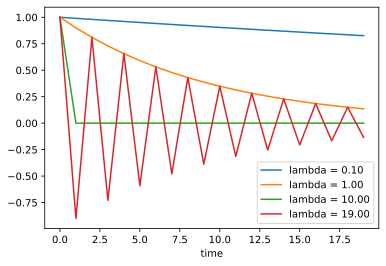

In [16]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

To analyze convergence in the case of momentum we begin by rewriting the update equations in terms of two scalars: one for $x$ and one for velocity $v$:

\begin{split}
\begin{bmatrix} 
v_{t+1} \\ x_{t+1} \end{bmatrix} =
\begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix}
\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} 
\end{bmatrix}
\end{split}

where $\mathbf{R}$ is the $2\times 2$ governing convergence behavior. After $t$ steps the initial choice $[v_0, x_0]$ becomes $\mathbf{R}(\beta, \eta, \lambda)^t [v_0, x_0]$. Hence, it is up to the eigenvalues of $\mathbf{R}$ to determine the speed of convergence.

## 12.7. Adagrad

### 12.7.1. Sparse Features and Learning Rates

To train a language model, we typically decrease the learning rate as we keep on training, usually at a rate of $\mathcal{O}(t^{-\frac{1}{2}})$ or slower to get good accuracy. For a model training on sparse features, i.e., features that occur only infrequently, model parameters associated with infrequent features only receive meaningful updates whenever these features occur. Given a decreasing learning rate we may end up in a situation where the parameters for common features converge rather quickly to their optimal values, whereas for infrequent features we are still short of observing them sufficiently frequently before their optimal values can be learned.

Therefore, rather than choosing a learning rate of the form 
\begin{split}
\eta = \frac{\eta_0}{\sqrt{t + c}}
\end{split}
we could use
\begin{split}
\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}
\end{split}
where $s(i, t)$ counts the number of nonzeros for feature $i$ that we have observed up to time $t$. However, this fails whenever we do not quite have sparsity but rather just data where the gradients are often very small and only rarely large.

### 12.7.2. Preconditioning

Consider to minimizing a function
\begin{split}
f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b
\end{split}

It is possible to rewrite in terms of its eigendecomposition $\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$ to arrive at a much simplified problem where each coordinate can be solved individually:
\begin{split}
f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.
\end{split}
where $\bar{\mathbf{x}} = \mathbf{U} \mathbf{x}$ and consequently $\bar{\mathbf{c}} = \mathbf{U} \mathbf{c}$. The modified problem has as its minimizer $\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$ and minimum value $-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$. This is much easier to compute since $\boldsymbol{\Lambda}$ is a diagonal matrix containing the eigenvalues of $\mathbf{Q}$.

The ratio between the largest and the smallest eigenvalue is the condition number of an optimization problem:
\begin{split}
\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}.
\end{split}
If the condition number $\kappa$ is large, it is difficult to solve the optimization problem accurately. 

while computing eigenvalues exactly may be expensive, guessing them and computing them even somewhat approximately may already be a lot better than not doing anything. We can use the diagonal entries of $\mathbf{Q}$ and rescale it accordingly:
\begin{split}
\tilde{\mathbf{Q}} = \textrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \textrm{diag}^{-\frac{1}{2}}(\mathbf{Q}).
\end{split}
In this case, we have $\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$ and specifically $\tilde{\mathbf{Q}}_{ii} = 1$ for all $i$. In most cases this simplifies the condition number significantly.

However, in deep learning we do not even have access to the second derivative of the objective function: for $\mathbf{x}\in \mathbb{R}^d$ the second derivative on a minibatch may require $\mathcal{O}(d^2)$ space and work to compute.

The idea of Adagrad is to use a proxy for that elusive diagonal of the Hessian that is both relatively cheap to compute and effective. Recall the function again:
\begin{split}
\bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.
\end{split}
The gradient is given by
\begin{split}
\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right),
\end{split}
where $\bar{\mathbf{x}}_0$ is the minimizer of $\bar{f}$. Hence the magnitude of the gradient depends both on $\boldsymbol{\Lambda}$ and the distance from optimality. If $\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$ did not change, this would be all that is needed.

Since AdaGrad is a stochastic gradient descent algorithm, we will see gradients with nonzero variance even at optimality.

### 12.7.3. The Algorithm

To formalize the previous discussion, we use the variable $\mathbf{s}_t$ to accumulate past gradient variance as follows:
\begin{split}\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}\end{split}
where the operations are applied coordinate-wise. That is, $\mathbf{v}^2$ has entries $v_i^2$. Likewise $\frac{1}{\sqrt{\mathbf{v}}}$ has entries $\frac{1}{\sqrt{v_i}}$ and $\mathbf{u} \cdot \mathbf{v}$ has entries $u_i v_i$. $\eta$ is still the learning rate and $\epsilon$ is an additive constant that ensures that we do not divide by zero. Lastly, we initialize $\mathbf{s}_0 = 0$.

Just like we keep track of an auxiliary variable in the momentum, in Adagrad we allow for an individual learning rate per coordinate.

Accumulating squared gradients in $\mathbf{s}_t$ means that $\mathbf{s}_t$ grows essentially at linear rate, which leads to an $\mathcal{O}(t^{-\frac{1}{2}})$ learning rate. In deep learning, we may want to decrease the learning rate rather more slowly. 

We still use the same objective function as previously, 
\begin{split}
f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2,
\end{split}
We keep the same learning rate $\eta = 0.4$ as before:

In [1]:
%matplotlib inline
import math
import torch

from d2l import torch as d2l

In [2]:
def f_2d(x1, x2):
    # objective function
    return 0.1 * x1**2 + 2 * x2**2

def adagrad_2d(x1, x2, s1, s2):
    # adagrad algorithm
    eps = 1e-6
    # update s1 and s2
    g1 = 0.2 * x1
    g2 = 4 * x2
    # accumulate squared gradient
    s1 += g1**2
    s2 += g2**2
    # update x1 and x2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2

    return x1, x2, s1, s2

epoch 20, x1: -2.382563, x2: -0.158591


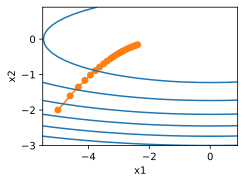

In [3]:
# learning rate
eta = 0.4

d2l.show_trace_2d(
    f_2d,
    d2l.train_2d(adagrad_2d),
)

The iterative trajectory of the independent variable is much smoother than before, but due to the cumulative effect of $\mathbf{s}_t$, the learning rate continuous decays, so the independent variable does not move as much during later stages of iteration.

If we use a larger learning rate $\eta = 2$, 

epoch 20, x1: -0.002295, x2: -0.000000


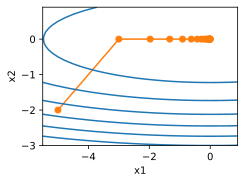

In [4]:
# learning rate
eta = 2

d2l.show_trace_2d(
    f_2d,
    d2l.train_2d(adagrad_2d),
)

This already indicates that the decrease in learning rate might be rather aggressive, even in the noise-free case and we need to ensure that parameters converge appropriately.

### 12.7.4. Implementation from Scratch

Just like the momentum method, Adagrad needs to maintain a state variable of the same shape as the parameters:

In [5]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6

    for p,s in zip(params, states):
        with torch.no_grad():
            # update s
            s[:] += torch.square(p.grad)
            # update p
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        # zero gradient
        p.grad.data.zero_()

For Adagrad, we can use a larger learning rate to train the model.

loss: 0.245, 0.088 sec/epoch


([0.04089021682739258,
  0.05592679977416992,
  0.06589961051940918,
  0.0748744010925293,
  0.08385062217712402,
  0.09382152557373047,
  0.10379743576049805,
  0.11277318000793457,
  0.12177348136901855,
  0.13077282905578613,
  0.1407468318939209,
  0.14972257614135742,
  0.15869951248168945,
  0.1676769256591797,
  0.17665386199951172],
 [0.26878920459747313,
  0.2617130579948425,
  0.244727048655351,
  0.2496279604434967,
  0.2433520453373591,
  0.24498327910900117,
  0.24295781822999318,
  0.244840864777565,
  0.24417798403898874,
  0.24313181670506795,
  0.24316929243008295,
  0.24362010153134664,
  0.2420620917081833,
  0.2422394433816274,
  0.2446988673210144])

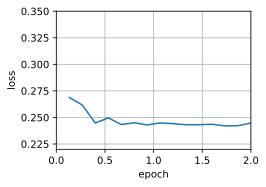

In [6]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)

d2l.train_ch11(
    adagrad,
    init_adagrad_states(feature_dim),
    {'lr': 0.1},
    data_iter,
    feature_dim
)

### 12.7.5. Concise Implementation

loss: 0.242, 0.073 sec/epoch


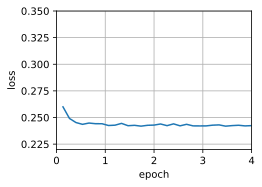

In [7]:
trainer = torch.optim.Adagrad

d2l.train_concise_ch11(
    trainer,
    {'lr': 0.1},
    data_iter
)

Notes:
1. Adagrad decreases the learning rate dynamically on a per-coordinate basis.
2. It uses the magnitude of the gradient as a means of adjusting how quickly progress is achieved - coordinates with large gradients are compensated with a smaller learning rate.
3. Computing the exact second derivative is typically infeasible in deep learning problems due to memory and computational constraints. The gradient can be a useful proxy.
4. If the optimization problem has a rather uneven structure Adagrad can help mitigate the distortion.
5. Adagrad is particularly effective for sparse features where the learning rate needs to decrease more slowly for infrequently occurring terms.
6. On deep learning problems Adagrad can sometimes be too aggressive in reducing learning rates. 

## 12.8. RMSProp

One of the key issues about Adagrad is that the learning rate decreases at a predefined schedule of effectively $\mathcal{O}(t^{-\frac{1}{2}})$. This may not be ideal for nonconvex problems.

### 12.8.1. The Algorithm

In RMSProp,
\begin{split}\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}\end{split}
The constant $\epsilon > 0$ is typically set to $10^{-6}$ to ensure that we do not suffer from division by zero or overly large step sizes. We are free to control the learning rate $\eta$ independently of the scaling that is applied on a per-coordinate basis. 

Expanding the definition of $\mathbf{s}_t$ yields
\begin{split}\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}\end{split}
Then we use $1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$ and the sum of weights is normalized to 1 with a half-life time of an observation of $\gamma^{-1}$.

The following code snippet visualizes the weights for the past 40 times steps for various choices of $\gamma$:

In [1]:
import math
import torch

from d2l import torch as d2l

Text(0.5, 0, 'time')

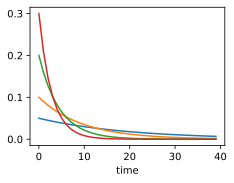

In [2]:
d2l.set_figsize()

gammas = [0.95, 0.9, 0.8, 0.7]

for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(
        x,
        (1 - gamma) * gamma ** x,
        label=f'gamma = {gamma:.2f}'
    )
d2l.plt.xlabel('time')

### 12.8.2. Implementation from Scratch

As before we use $f(\mathbf{x})=0.1x_1^2+2x_2^2$ to observe the trajectory of RMSProp, and we set the learning rate to 0.4:

In [3]:
def f_2d(x1, x2):
    # objective function
    return 0.1 * x1**2 + 2 * x2**2

def rmsprop_2d(x1, x2, s1, s2):
    # gradients
    g1 = 0.2 * x1
    g2 = 4 * x2
    eps = 1e-6
    # update s1 and s2
    s1 = gamma * s1 + (1 - gamma) * g1**2
    s2 = gamma * s2 + (1 - gamma) * g2**2
    # update x1 and x2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2

    return x1, x2, s1, s2

epoch 20, x1: -0.010599, x2: 0.000000


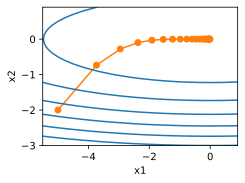

In [4]:
# learning rate
eta = 0.4
# gamma
gamma = 0.9

d2l.show_trace_2d(
    f_2d,
    d2l.train_2d(rmsprop_2d),
)

We can also implement RMSProp to be used in a deep network:

In [5]:
def init_rmsprop_states(feature_dim):
    # initiailize states
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma = hyperparams['gamma']
    eps = 1e-6

    for p,s in zip(params, states):
        with torch.no_grad():
            # update s
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            # update p
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)

        # zero gradient
        p.grad.data.zero_()

loss: 0.247, 0.105 sec/epoch


([0.04529857635498047,
  0.05935955047607422,
  0.07132697105407715,
  0.0812995433807373,
  0.09127306938171387,
  0.10323882102966309,
  0.11420989036560059,
  0.12717843055725098,
  0.13715171813964844,
  0.1471245288848877,
  0.15610003471374512,
  0.1670701503753662,
  0.18369793891906738,
  0.19566631317138672,
  0.21062493324279785],
 [0.3621979482968648,
  0.29323769013086953,
  0.26729329323768614,
  0.25395872894922894,
  0.2458301149805387,
  0.2487287395000458,
  0.24525810086727143,
  0.24396895643075306,
  0.24349593406915665,
  0.24492456050713857,
  0.2427549443046252,
  0.24469808427492779,
  0.2451303744514783,
  0.24298795672257742,
  0.24700443842013678])

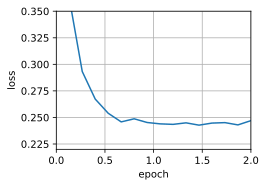

In [6]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)

d2l.train_ch11(
    rmsprop,
    init_rmsprop_states(feature_dim),
    {'lr': 0.01, 'gamma': 0.9},
    data_iter,
    feature_dim
)

### 12.8.3. Concise Implementation

loss: 0.244, 0.081 sec/epoch


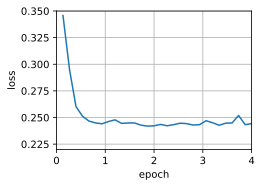

In [7]:
trainer = torch.optim.RMSprop

d2l.train_concise_ch11(
    trainer,
    {'lr': 0.01, 'alpha': 0.9},
    data_iter
)

Notes:
1. RMSProp is very similar to Adagrad insofar as both use the square of the gradient to scale coefficients.
2. RMSProp shares with momentum the leaky averaging. However, RMSProp uses the technique to adjust the coefficient-wise preconditioner.
3. The learning rate needs to be scheduled by the experimenter in practice.
4. The coefficient $\gamma$ determines how long the history is when adjusting the per-coordinate scale.

## 12.9. Adadelta

Another variant of AdaGrad. The main difference is that it decreases the amount by which the learning rate is adaptive to coordinates.

### 12.9.1. The Algorithm

Adadelta uses two state variables, $\mathbf{s}_t$ to store a leaky average of the second moment of the gradient and $\Delta\mathbf{x}_t$ to store a leaky average of the second moment of the change of parameters in the model itself.

Given the parameters $\rho$ and $\epsilon$ (both are hyperparameters), we obtain the following leaky updates:
\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}

The difference to RMSProp is that we perform updates with the **rescaled gradient** $\mathbf{g}_t'$, i.e.,
\begin{split}\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}\end{split}
The rescaled gradient $\mathbf{g}_t'$ is computed as
\begin{split}\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}\end{split}
where $\Delta\mathbf{x}_t$ is the leaky average of the squared rescaled gradients $\mathbf{g}_t'$. We initialize $\Delta\mathbf{x}_0 = 0$ and update it at each time step with $\mathbf{g}_t'$:
\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}
and $\epsilon$ is a constant to maintain numerical stability, such as $10^{-5}$.

### 12.9.2. Implementation

Adadelta needs to maintain two state variables for each variable, $\mathbf{s}_t$ and $\Delta\mathbf{x}_t$.

In [8]:
%matplotlib inline
import torch

from d2l import torch as d2l

In [9]:
def init_adadelta_states(feature_dim):
    # initialize states
    s_w = torch.zeros((feature_dim, 1))
    delta_w = torch.zeros((feature_dim, 1))

    s_b = torch.zeros(1)
    delta_b = torch.zeros(1)

    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho = hyperparams['rho']
    eps = 1e-5

    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # in-place updates via [:]
            # update s
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            # update g
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            # update p
            p[:] -= g
            # update delta
            delta[:] = rho * delta + (1 - rho) * g * g
        
        # zero gradient
        p.grad.data.zero_()

Choosing $\rho=0.9$ amounts to a half-life time of 10 for each parameter update.

loss: 0.243, 0.097 sec/epoch


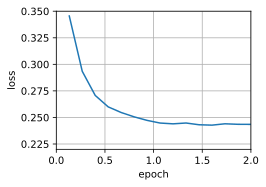

In [11]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)

d2l.train_ch11(
    adadelta,
    init_adadelta_states(feature_dim),
    {'rho': 0.9},
    data_iter,
    feature_dim
);

loss: 0.243, 0.082 sec/epoch


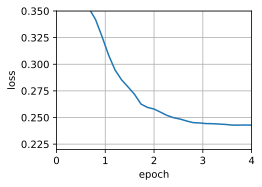

In [12]:
# concise implementation
trainer = torch.optim.Adadelta

d2l.train_concise_ch11(
    trainer,
    {'rho': 0.9},
    data_iter
)

Notes:
1. Adadelta has no learning rate parameter. It uses the rate of change in the parameters itself to adapt the learning rate.
2. Adadelta requires two state variables to store the second moments of gradient and the change in parameters.
3. Adadelta uses leaky averages to keep a running estimate of the appropriate statistics.

## 12.10. Adam

Adam combines all previous techniques into one efficient learning algorithm.

### 12.10.1. The Algorithm

Adam uses exponential weighted moving averages (also known as leaky averaging) to obtain an estimate of both the momentum and also the second moment of the gradient. That is, it uses the state variables
\begin{split}\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}\end{split}
where $\beta_1$ and $\beta_2$ are nonnegative weighting parameters. Common choices for them are $\beta_1 = 0.9$ and $\beta_2 = 0.999$. That is, the variance estimate moves *much more slowly* than the momentum term.

If we initialize $\mathbf{v}_0 = \mathbf{s}_0 = 0$, we have a significant amount of bias initially towards smaller values. This can be addressed by using 
\begin{split}
\sum_{i=0}^{t-1} \beta^i = \frac{1 - \beta^t}{1 - \beta}
\end{split}
to re-normalize terms.

Correspondingly, the normalized state variables are given by
\begin{split}
\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \textrm{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.
\end{split}

For the update equations, we first rescale the gradient similar to RMSProp to obtain
\begin{split}
\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.
\end{split}
Here we update the momemtum $\hat{\mathbf{v}}_t$. There is also a slight difference as the rescaling happens using $\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$ rather than $\frac{1}{\sqrt{\mathbf{s}_t} + \epsilon}$ as in RMSProp.

The update equations are given by
\begin{split}
\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.
\end{split}

### 12.10.2. Implementation

In [13]:
%matplotlib inline
import torch

from d2l import torch as d2l

In [14]:
def init_adam_states(feature_dim):
    # initialize states
    v_w = torch.zeros((feature_dim, 1))
    s_w = torch.zeros((feature_dim, 1))

    v_b = torch.zeros(1)
    s_b = torch.zeros(1)

    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-6

    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            # update v
            v[:] = beta1 * v + (1 - beta1) * p.grad
            # update s
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            # re-normalize v and s
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            # update p
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)

        # zero gradient
        p.grad.data.zero_()

    hyperparams['t'] += 1

We need to store the time step counter `t` in the `hyperparams` dictionary.

We can test our implementation with a learning rate of $\eta = 0.01$:

loss: 0.245, 0.115 sec/epoch


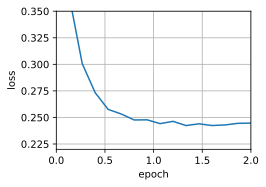

In [15]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)

d2l.train_ch11(
    adam,
    init_adam_states(feature_dim),
    {'lr': 0.01, 't': 1},
    data_iter,
    feature_dim
);

loss: 0.244, 0.087 sec/epoch


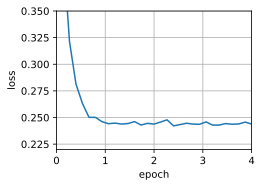

In [16]:
# concise implementation
trainer = torch.optim.Adam

d2l.train_concise_ch11(
    trainer,
    {'lr': 0.01},
    data_iter
)

### 12.10.3. Yogi

One of the problems of Adam is that it can fail to converge even in convex settings when the second moment estimate in $\mathbf{s}_t$ blows up. We can rewrite the Adam update from
\begin{split}
\mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2,
\end{split}
to
\begin{split}
\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).
\end{split}

Whenever $\mathbf{g}_t^2$ has high variance or updates are sparse, $\mathbf{s}_t$ may forget past values too quickly. To counteract this, we can replace $\mathbf{g}_t^2 - \mathbf{s}_{t-1}$ by $\mathbf{g}_t^2 \odot \mathop{\textrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$. Now the magnitude of the update no long depends on the amount of deviation. This yields the Yogi updates
\begin{split}
\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\textrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).
\end{split}

In [22]:
def yogi(params, states, hyperparams):
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-3

    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            # update v
            v[:] = beta1 * v + (1 - beta1) * p.grad
            # update s
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s
            ) * torch.square(p.grad)
            # re-normalize v and s
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            # update p
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)

        # zero gradient
        p.grad.data.zero_()
    
    hyperparams['t'] += 1

loss: 0.243, 0.101 sec/epoch


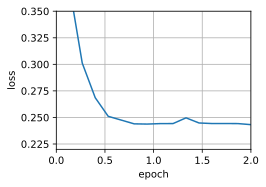

In [23]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)

d2l.train_ch11(
    yogi,
    init_adam_states(feature_dim),
    {'lr': 0.01, 't': 1},
    data_iter,
    feature_dim
);

Notes:
1. Adam combines features of many optimization algorithms into a fairly robust update rule.
2. Created on the basis of RMSProp, Adam also uses EWMA on the minibatch stochastic gradient.
3. Adam uses bias correction to adjust for a slow startup when estimating momentum and a second moment.
4. For gradients with significant variance we may encounter issues with convergence. They can be amended by using larger minibatches or by switching to an improved estimate for $\mathbf{s}_t$ such as Yogi.

## 12.11. Learning Rate Scheduling

* The *magnitude* of the learning rate matters. If it is too large, optimization diverges, if it is too small, it takes too long to train or we end up with a suboptimal result.
* The rate of decay is just as important. If the learning rate remains large we may simply end up bouncing around the minimum and thus not reach optimality.
* Initialization matters. This pertains both to how the parameters are set initially and also how they evolve initially.

### 12.11.1. Toy Problem

Training a LeNet on Fashion-MNIST data.

In [24]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler

from d2l import torch as d2l

In [25]:
# neural network
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16*5*5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )

    return model

In [26]:
# loss function
loss = nn.CrossEntropyLoss()
# device
device = d2l.try_gpu()

# batch size
batch_size = 256
# load data
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [27]:
# training function
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler=None):
    # send model to device
    net.to(device)
    # initialize animation
    animator = d2l.Animator(
        xlabel='epoch', xlim=[0, num_epochs],
        legend=['train loss', 'train acc', 'test acc']
    )

    # training loop
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3) # train_loss, train_acc, num_examples

        for i, (X, y) in enumerate(train_iter):
            # training mode
            net.train()
            # zero gradient
            trainer.zero_grad()
            # send data to device
            X, y = X.to(device), y.to(device)

            # forward pass
            y_hat = net(X)
            # compute loss
            l = loss(y_hat, y)
            # backward pass
            l.backward()
            # update parameters
            trainer.step()

            # update metric
            with torch.no_grad():
                metric.add(
                    l * X.shape[0], # train_loss
                    d2l.accuracy(y_hat, y), # train_acc
                    X.shape[0] # num_examples
                )
            
            # compute average loss and accuracy of training data
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # update animation for every 50 batches
            if (i + 1) % 50 == 0:
                animator.add(
                    epoch + i / len(train_iter),
                    (train_loss, train_acc, None)
                )

        # compute average accuracy of test data
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        # update animation
        animator.add(epoch + 1, (None, None, test_acc))

        # if scheduler is defined, update learning rate
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # using PyTorch scheduler
                scheduler.step()
            else:
                # using custom scheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    # print final results
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

If we invoke the algorithm with default settings, such as a learning rate of 0.3 and train for 30 epochs.

In [28]:
# learning rate
lr = 0.3
# number of epochs
num_epochs = 30
# create model
net = net_fn()

train loss 0.140, train acc 0.946, test acc 0.897


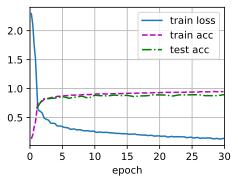

In [29]:
# optimizer
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

The training accuracy keeps on increasing while progress in terms of test accuracy stalls beyond a point. This gap between both curves indicates overfitting.

### 12.11.2. Schedulers

One way of adjusting the learning rate is to set it explicitly at each step, which is achieved by the `set_learning_rate` method.

In [30]:
# learning rate
lr = 0.1

trainer.param_groups[0]['lr'] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


When invoked with the number of updates it returns the appropriate value of the learning rate. We can define a simple function that sets the learning rate to
\begin{split}
\eta = \eta_0 (t + 1)^{-\frac{1}{2}}
\end{split}

In [31]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * (num_update + 1) ** (-0.5)

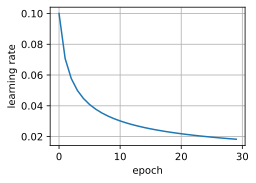

In [33]:
scheduler = SquareRootScheduler(lr=0.1)

d2l.plot(
    torch.arange(num_epochs),
    [scheduler(t) for t in range(num_epochs)],
    xlabel='epoch',
    ylabel='learning rate'
)

Now we can provide the scheduler to the trainer and observe the change in the learning rate over time.

train loss 0.288, train acc 0.893, test acc 0.879


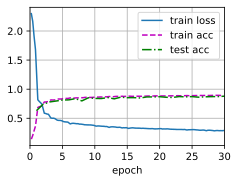

In [34]:
# learning rate
lr = 0.1
# create model
net = net_fn()
# optimizer
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

The curve was rather more smooth than previously and there was less overfitting.

### 12.11.3. Policies

Common choices are polynomial decay and piecewise constant schedules. In addition, cosine learning rate schedules have been found to work well empirically on some problems. Lastly, on some problems it is beneficial to warm up the optimizer prior to using large learning rates.

#### 12.11.3.1. Factor Scheduler

One alternative to a polynomial decay would be a multiplicative one, that is,
\begin{split}
\eta_{t+1} \leftarrow \eta_t \cdot \alpha
\end{split}
for $\alpha\in (0,1)$. To prevent the learning rate from decaying beyond a reasonable lower bound the update equation is often modified to
\begin{split}
\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha).
\end{split}

In [35]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

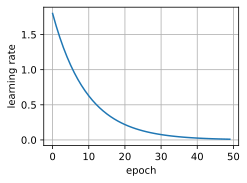

In [36]:
scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)

d2l.plot(
    torch.arange(50),
    [scheduler(t) for t in range(50)],
    xlabel='epoch',
    ylabel='learning rate'
)

train loss 0.273, train acc 0.901, test acc 0.883


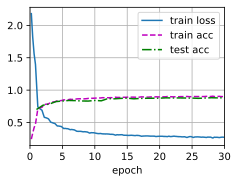

In [37]:
# learning rate
lr = 0.1
# create model
net = net_fn()
# optimizer
trainer = torch.optim.SGD(net.parameters(), lr=lr)
# scheduler
scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=lr)

train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

#### 12.11.3.2. Multi-Factor Scheduler

A common strategy for training deep networks is to keep the learning rate piecewise constant and to decrease it by a given amount every so often. That is, given a set of times when to decrease the rate, such as $s = \{5, 10, 20\}$ decrease $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ whenever $t \in s$. Assuming that the values are halves at each step we can implement this as follows:

In [38]:
# learning rate
lr = 0.5
# create model
net = net_fn()
# optimizer
trainer = torch.optim.SGD(net.parameters(), lr=lr)

scheduler = lr_scheduler.MultiStepLR(
    trainer, # optimizer
    milestones=[15, 30], # learning rate decay at 15th and 30th epochs
    gamma=0.5 # learning rate decay factor
)

In [39]:
def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

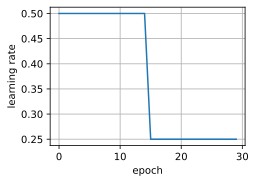

In [40]:
d2l.plot(
    torch.arange(num_epochs), 
    [get_lr(trainer, scheduler) for t in range(num_epochs)],
    xlabel='epoch',
    ylabel='learning rate'
)

The intuition behind this piecewise constant learning rate schedule is that one lets optimization proceed until a stationary point has been reached in terms of the distribution of weight vectors. Then (and only then) do we decrease the rate such as to obtain a higher quality proxy to a good local minimum.

train loss 0.208, train acc 0.921, test acc 0.893


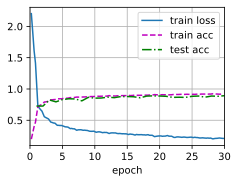

In [41]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

#### 12.11.3.3. Cosine Scheduler

The cosine scheduler does not decrease the learning rate too drastically in the beginning and allows us to "refine" the solution in the end using a very small learning rate. In the range $t\in[0, T]$, the learning rate is given by
\begin{split}
\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)
\end{split}
where $\eta_0$ is the initial learning rate, $\eta_T$ is the target learning rate at time $T$. For $t>T$, we simply use $\eta_T$ without increasing it again.

In [43]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0, warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr

        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                    * float(epoch) / float(self.warmup_steps)
        
        return self.warmup_begin_lr + increase
    
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (self.base_lr_orig - self.final_lr) \
                            * (1 + math.cos(math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
            
        return self.base_lr

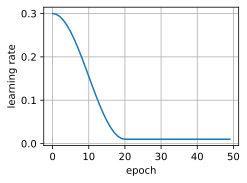

In [44]:
scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)

d2l.plot(
    torch.arange(50),
    [scheduler(t) for t in range(50)],
    xlabel='epoch',
    ylabel='learning rate'
)

In the context of computer vision this schedule can lead to improved results. Note, though, that such improvements are not guaranteed.

train loss 0.161, train acc 0.941, test acc 0.901


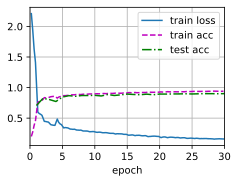

In [45]:
# learning rate
lr = 0.3
# create model
net = net_fn()
# optimizer
trainer = torch.optim.SGD(net.parameters(), lr=lr)
# scheduler
scheduler = CosineScheduler(max_update=num_epochs, base_lr=lr, final_lr=0.01)

train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

#### 12.11.3.4. Warmup

In some cases initializing the parameters is not sufficient to guarantee a good solution. This is particularly a problem for some advanced network designs that may lead to unstable optimization problems. We could address this by choosing a sufficiently small learning rate to prevent divergence in the beginning. Unfortunately this means that progress is slow. Conversely, a large learning rate initially leads to divergence.

We can use a warmup period during which the learning rate *increases* to its initial maximum and to cool down the rate until the end of the optimization process.

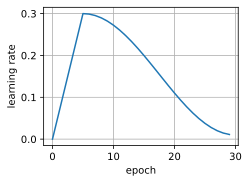

In [46]:
# learning rate
lr = 0.3
# warmup steps
warmup_steps = 5

scheduler = CosineScheduler(
    max_update=num_epochs,
    base_lr=lr,
    final_lr=0.01,
    warmup_steps=warmup_steps,
    warmup_begin_lr=0
)

d2l.plot(
    torch.arange(num_epochs),
    [scheduler(t) for t in range(num_epochs)],
    xlabel='epoch',
    ylabel='learning rate'
)

train loss 0.204, train acc 0.924, test acc 0.887


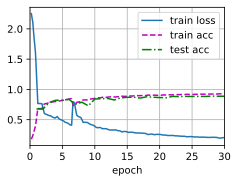

In [47]:
# create model
net = net_fn()
# optimizer
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

Warmup can be applied to any scheduler (not just cosine). A warmup phase limits the amount of divergence of parameters in very deep networks.